**Import library**

In [ ]:
!pip install sklearn
!pip install matplotlib.pyplot
!pip install eli5

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import log_loss, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import *
from sklearn.svm import *
from sklearn.ensemble import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import math
import warnings
import seaborn as sns
import scipy.stats as stats
import eli5

import joblib

plt.rcParams['figure.figsize'] = [12,6]
warnings.filterwarnings('ignore')

path = "/content/online_shoppers_intention.csv"
df1 = pd.read_csv(path)
df1.dataframeName = 'online_shoppers_intention.csv'

ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot


**Functions**

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include=[np.number])  # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]]  # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10:  # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k=1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center',
                          va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

# Clustering
def find_clusters(X, start=1, end=11):
    """
    data: array like
    """
    inertias = []

    for i in range(start, end):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    plt.plot(np.arange(start, end), np.array(inertias), color='orange', marker='o')
    plt.xlabel('No. of clusters')
    plt.ylabel('Inertia')
    plt.title("Elbow Curve", fontsize=16)
    plt.show()

def draw_optimal_clusters(X, n_clusters=2, xlabel=None, ylabel=None, title=None):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)

    y_means = kmeans.predict(X)
    centers = kmeans.cluster_centers_

    plt.scatter(X[y_means == 0, 0], X[y_means == 0, 1], color='lightblue', label='Uninterested Customers')
    plt.scatter(X[y_means == 1, 0], X[y_means == 1, 1], color='orange', label='Interested Customers')
    plt.scatter(centers[:, 0], centers[:, 1], s=100, label='Centers')

    plt.legend()

    plt.title(title, fontsize=20)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def predict_RandomForest_28(model, X):
  """
  For RandomForest_28 (28 variables)
  """
  d = pd.DataFrame(X)
  df = d
  d_ = pd.get_dummies(df)
  col = ['Month_Aug', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June',
        'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep',
        'VisitorType_New_Visitor', 'VisitorType_Other',
        'VisitorType_Returning_Visitor']
  df = d_.reindex(d_.columns.union(col, sort=False), axis=1, fill_value=0)
  return model.predict(df)[0]

def predict(model, X):
  """
  For other model exept RandomForest_28 (28 variables) 
  """
  d = pd.DataFrame(X)
  shopping_clean = d.drop(['Month', 'Browser', 'OperatingSystems', 'Region', 'TrafficType', 'Weekend'], axis=1)
  # Encoding Vistor Type
  visitor_encoded = pd.get_dummies(shopping_clean['VisitorType'], prefix='Visitor_Type', drop_first=True)
  d_ = pd.concat([shopping_clean, visitor_encoded], axis=1).drop(['VisitorType'], axis=1)
  col = ['Visitor_Type_Other', 'Visitor_Type_Returning_Visitor']
  d_ = d_.reindex(d_.columns.union(col, sort=False), axis=1, fill_value=0)
  return model.predict(d_)[0]

**Data analysis 1**


In [ ]:
#Data analysis
df1 = pd.read_csv(path)
#Manuel analysis - ok
def plotting_visitor_and_browser_pie():
    # Plotting visitors
    df1['VisitorType'].value_counts()
    # plotting a pie chart for browsers
    plt.rcParams['figure.figsize'] = (18, 7)
    size = [10551, 1694, 85]
    colors = ['violet', 'magenta', 'pink']
    labels = "Returning Visitor", "New_Visitor", "Others"
    explode = [0, 0, 0.1]
    plt.subplot(1, 2, 1)
    plt.pie(size, colors=colors, labels=labels, explode=explode, shadow=True, autopct='%.2f%%')
    plt.title('Different Visitors', fontsize=30)
    plt.axis('off')
    plt.legend()
    # plotting a pie chart for browsers
    size = [7961, 2462, 736, 467, 174, 163, 300]
    colors = ['orange', 'yellow', 'pink', 'crimson', 'lightgreen', 'cyan', 'blue']
    labels = "2", "1", "4", "5", "6", "10", "others"
    plt.subplot(1, 2, 2)
    plt.pie(size, colors=colors, labels=labels, shadow=True, autopct='%.2f%%', startangle=90)
    plt.title('Different Browsers', fontsize=30)
    plt.axis('off')
    plt.legend()
    plt.show()
#Revenue - ok
def plotting_interersting():

    # product related duration vs revenue
    plt.rcParams['figure.figsize'] = (18, 15)
    plt.subplot(2, 2, 1)
    sns.boxenplot(df1['Revenue'], df1['Informational_Duration'], palette='rainbow')
    plt.title('Info. duration vs Revenue', fontsize=30)
    plt.xlabel('Info. duration', fontsize=15)
    plt.ylabel('Revenue', fontsize=15)
    # product related duration vs revenue
    plt.subplot(2, 2, 2)
    sns.boxenplot(df1['Revenue'], df1['Administrative_Duration'], palette='pastel')
    plt.title('Admn. duration vs Revenue', fontsize=30)
    plt.xlabel('Admn. duration', fontsize=15)
    plt.ylabel('Revenue', fontsize=15)
    # product related duration vs revenue
    plt.subplot(2, 2, 3)
    sns.boxenplot(df1['Revenue'], df1['ProductRelated_Duration'], palette='dark')
    plt.title('Product Related duration vs Revenue', fontsize=30)
    plt.xlabel('Product Related duration', fontsize=15)
    plt.ylabel('Revenue', fontsize=15)
    # exit rate vs revenue
    plt.subplot(2, 2, 4)
    sns.boxenplot(df1['Revenue'], df1['ExitRates'], palette='spring')
    plt.title('ExitRates vs Revenue', fontsize=30)
    plt.xlabel('ExitRates', fontsize=15)
    plt.ylabel('Revenue', fontsize=15)
    plt.show()
    print()

    # page values vs revenue
    plt.rcParams['figure.figsize'] = (18, 7)
    plt.subplot(1, 2, 1)
    sns.stripplot(df1['Revenue'], df1['PageValues'], palette='autumn')
    plt.title('PageValues vs Revenue', fontsize=30)
    plt.xlabel('PageValues', fontsize=15)
    plt.ylabel('Revenue', fontsize=15)
    # bounce rates vs revenue
    plt.subplot(1, 2, 2)
    sns.stripplot(df1['Revenue'], df1['BounceRates'], palette='magma')
    plt.title('Bounce Rates vs Revenue', fontsize=30)
    plt.xlabel('Boune Rates', fontsize=15)
    plt.ylabel('Revenue', fontsize=15)
    plt.show()
    print()

    # month vs pagevalues wrt revenue
    plt.rcParams['figure.figsize'] = (18, 15)
    plt.subplot(2, 2, 1)
    sns.boxplot(x=df1['Month'], y=df1['PageValues'], hue=df1['Revenue'], palette='inferno')
    plt.title('Mon. vs PageValues w.r.t. Rev.', fontsize=30)
    # month vs exitrates wrt revenue
    plt.subplot(2, 2, 2)
    sns.boxplot(x=df1['Month'], y=df1['ExitRates'], hue=df1['Revenue'], palette='Reds')
    plt.title('Mon. vs ExitRates w.r.t. Rev.', fontsize=30)
    # month vs bouncerates wrt revenue
    plt.subplot(2, 2, 3)
    sns.boxplot(x=df1['Month'], y=df1['BounceRates'], hue=df1['Revenue'], palette='Oranges')
    plt.title('Mon. vs BounceRates w.r.t. Rev.', fontsize=30)
    # visitor type vs exit rates w.r.t revenue
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df1['VisitorType'], y=df1['BounceRates'], hue=df1['Revenue'], palette='Purples')
    plt.title('Visitors vs BounceRates w.r.t. Rev.', fontsize=30)
    plt.show()
    print()

    # visitor type vs exit rates w.r.t revenue
    plt.rcParams['figure.figsize'] = (18, 15)
    plt.subplot(2, 2, 1)
    sns.violinplot(x=df1['VisitorType'], y=df1['ExitRates'], hue=df1['Revenue'], palette='rainbow')
    plt.title('Visitors vs ExitRates wrt Rev.', fontsize=30)
    # visitor type vs exit rates w.r.t revenue
    plt.subplot(2, 2, 2)
    sns.violinplot(x=df1['VisitorType'], y=df1['PageValues'], hue=df1['Revenue'], palette='gnuplot')
    plt.title('Visitors vs PageValues wrt Rev.', fontsize=30)
    # region vs pagevalues w.r.t. revenue
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df1['Region'], y=df1['PageValues'], hue=df1['Revenue'], palette='Greens')
    plt.title('Region vs PageValues wrt Rev.', fontsize=30)
    # region vs exit rates w.r.t. revenue
    plt.subplot(2, 2, 4)
    sns.violinplot(x=df1['Region'], y=df1['ExitRates'], hue=df1['Revenue'], palette='spring')
    plt.title('Region vs Exit Rates w.r.t. Revenue', fontsize=30)
    plt.show()
    print()
#ok
def Other_plotting_other_variables():
    continuous_features = ['Administrative_Duration',
                           'Informational_Duration',
                           'ProductRelated_Duration',
                           'BounceRates',
                           'ExitRates',
                           'PageValues']
    discrete_features = ['Administrative', 'Informational',
                         'ProductRelated', 'Month',
                         'OperatingSystems', 'Browser',
                         'Region', 'TrafficType',
                         'VisitorType', 'Weekend']
    chi_squared_df = pd.DataFrame(columns=['feature', 'pval', 'dependent'])
    for i, col in enumerate(discrete_features):
        x = df1.groupby(['Revenue', col])[col].count().unstack(1).fillna(0).astype('int')
        res = stats.chi2_contingency(x.values)
        pval = res[1]
        if pval < 0.05:
            dependent = 'Yes'
        else:
            dependent = 'No'
        chi_squared_df.loc[i] = [col, round(pval, 3), dependent]
    chi_squared_df

    continuous_features
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 20))
    axs = np.ravel(axs)
    for i, col in enumerate(continuous_features):
        plt.sca(axs[i])
        sns.violinplot(data=df1, x='Revenue', y=col)
    plt.tight_layout()
    plt.show()
    print()
#ok
def plotting_data_analysis_revenue_false_true():
    # Data vizualisation
    customer = pd.read_csv(path)
    customer_copy = customer.copy()
    plt.figure(figsize=(15, 5))
    # plt.style.use('seaborn-white')
    plt.subplot(131)
    sns.scatterplot(x="Administrative", y="Administrative_Duration", hue="Revenue", data=customer_copy)
    plt.subplot(132)
    sns.scatterplot(x="Informational", y="Informational_Duration", hue="Revenue", data=customer_copy)
    plt.subplot(133)
    sns.scatterplot(x="ProductRelated", y="ProductRelated_Duration", hue="Revenue", data=customer_copy)
    plt.show()
    print()

    sns.relplot(x="BounceRates", y="ExitRates", col="Revenue", hue="Revenue", style="Weekend", data=customer_copy)
    plt.show()
    print()

    sns.catplot(x="VisitorType", y="ExitRates",
                hue="Weekend", col="Revenue",
                data=customer_copy, kind="box");
    plt.show()
    print()
#--------------------------------

#Plots général - ok
def plotting_data_analysis_other_2():
    # DATA Vizualization
    df = pd.read_csv(path)
    fig, ax = plt.subplots(4, 2, figsize=(14, 14))
    fig.tight_layout(pad=4)
    sns.countplot(df['SpecialDay'], palette='dark', ax=ax[0, 0])
    sns.countplot(df['Month'], palette='dark', ax=ax[0, 1])
    sns.countplot(df['OperatingSystems'], palette='dark', ax=ax[1, 0])
    sns.countplot(df['Browser'], palette='dark', ax=ax[1, 1])
    sns.countplot(df['Region'], palette='dark', ax=ax[2, 0])
    sns.countplot(df['TrafficType'], palette='dark', ax=ax[2, 1])
    sns.countplot(df['VisitorType'], palette='dark', ax=ax[3, 0])
    sns.countplot(df['Weekend'], palette='dark', ax=ax[3, 1])
    plt.show()
    print()
    # Matrice de confusion
    plt.figure(figsize=(18, 14))
    sns.heatmap(df.corr(), cmap='Blues', annot=True)
    plt.show()

#----------------------------------
#Linear regression and Hear Map - ok
def plotting_LR_HeatMap():
    # Bounce Rate vs Exit Rate
    sns.lmplot(x="BounceRates", y="ExitRates", data=df1,
               scatter_kws={'alpha': 0.3},
               line_kws={'color': 'red', 'ls': '--'})
    plt.show()

    # Page Value versus Bounce Rate
    sns.lmplot(x="PageValues", y="BounceRates",
               data=df1, scatter_kws={'alpha': 0.2},
               line_kws={'color': 'red', 'ls': '--'})
    plt.show()

    # Page Value versus Exit Rate
    sns.lmplot(x="PageValues", y="ExitRates",
               data=df1, scatter_kws={'alpha': 0.2},
               line_kws={'color': 'red', 'ls': '--'})
    plt.show()

    # Impact of Administrative Page Views and Administrative Pageview Duration on Revenue
    sns.lmplot(x="Administrative", y="Administrative_Duration",
               hue='Revenue', data=df1, scatter_kws={'alpha': 0.5})
    plt.show()

    # Impact of Information Page Views and Information Pageview Duration on Revenue
    sns.lmplot(x="Informational", y="Informational_Duration",
               hue='Revenue', data=df1, scatter_kws={'alpha': 0.5})
    plt.show()

    # Impact of ProductRelated Page Views and ProductRelated Pageview Duration on Revenue
    sns.lmplot(x="ProductRelated", y="ProductRelated_Duration",
               hue='Revenue', data=df1, scatter_kws={'alpha': 0.5})
    plt.show()

    google_analytics_features = ['BounceRates', 'ExitRates', 'PageValues']
    corr_mat = df1[google_analytics_features].corr()
    sns.heatmap(corr_mat, annot=True, annot_kws={'fontsize': 16}, fmt='.3g', linewidths=2, cmap='Pastel1')
    plt.show()

    type_of_pages = ['Administrative', 'Informational', 'ProductRelated']
    corr_mat = df1[type_of_pages].corr(method='spearman')
    sns.heatmap(corr_mat, annot=True, annot_kws={'fontsize': 16}, fmt='.3g', linewidths=2, cmap='Pastel1')
    plt.show()

    # lm plot
    plt.rcParams['figure.figsize'] = (20, 10)
    sns.lmplot(x='Administrative', y='Informational', data=df1, x_jitter=0.05)
    plt.title('LM Plot between Admistrative and Information', fontsize=15)
    plt.show()

#----------------------------------
#K-means - ok
def K_Means():
    # Performing K-means Clustering for Informational Duration versus Bounce Rate
    X = df1.iloc[:, [3, 6]].values
    find_clusters(X)
    draw_optimal_clusters(X, n_clusters=2, xlabel="Informational Duration",
                          ylabel="Bounce Rates",
                          title="Informational Duration vs Bounce Rates")

    # K-means Clustering for Informational Duration versus Exit Rate
    X = df1.iloc[:, [4, 7]].values
    find_clusters(X)
    draw_optimal_clusters(X, n_clusters=2, xlabel='Exit Rates',
                          ylabel='Informational Duration',
                          title='Informational Duration vs Exit Rates')

    # K-means Clustering for Administrative Duration versus Bounce Rate
    X = df1.iloc[:, [1, 6]].values
    find_clusters(X)
    draw_optimal_clusters(X, n_clusters=2, xlabel="Administrative Duration",
                          ylabel="Bounce Rates",
                          title="Administrative Duration vs Bounce Rates")

    X = df1.iloc[:, [1, 7]].values
    find_clusters(X)
    draw_optimal_clusters(X, n_clusters=2, xlabel="Administrative Duration",
                          ylabel="Exit Rate",
                          title="Administrative Duration Vs Exit Rate")

    x = df1.iloc[:, [3, 6]].values
    km = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
    y_means = km.fit_predict(x)
    plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1], s=100, c='pink', label='Un-interested Customers')
    plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1], s=100, c='yellow', label='General Customers')
    plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1], s=100, c='cyan', label='Target Customers')
    plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=50, c='blue', label='centeroid')
    plt.title('Administrative Duration vs Duration', fontsize=20)
    plt.grid()
    plt.xlabel('Administrative Duration')
    plt.ylabel('Bounce Rates')
    plt.legend()
    plt.show()

    x = df1.iloc[:, [1, 7]].values
    km = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
    y_means = km.fit_predict(x)
    plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1], s=100, c='pink', label='Un-interested Customers')
    plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1], s=100, c='yellow', label='Target Customers')
    plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=50, c='blue', label='centeroid')
    plt.title('Administrative Clustering vs Exit Rates', fontsize=20)
    plt.grid()
    plt.xlabel('Administrative Duration')
    plt.ylabel('Exit Rates')
    plt.legend()
    plt.show()

    # informational duration vs Bounce Rates
    x = df1.iloc[:, [13, 14]].values
    km = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
    y_means = km.fit_predict(x)
    plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1], s=100, c='pink', label='Un-interested Customers')
    plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1], s=100, c='yellow', label='Target Customers')
    plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=50, c='blue', label='centeroid')
    plt.title('Region vs Traffic Type', fontsize=20)
    plt.grid()
    plt.xlabel('Region')
    plt.ylabel('Traffic')
    plt.legend()
    plt.show()

    # informational duration vs Bounce Rates
    x = df1.iloc[:, [1, 13]].values
    km = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
    y_means = km.fit_predict(x)
    plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1], s=100, c='pink', label='Unproductive Customers')
    plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1], s=100, c='yellow', label='Target Customers')
    plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=50, c='blue', label='centeroid')
    plt.title('Adminstrative Duration vs Region', fontsize=20)
    plt.grid()
    plt.xlabel('Administrative Duration')
    plt.ylabel('Region Type')
    plt.legend()
    plt.show()

**Data vizualisation with graph of purchase **

There are 12330 rows and 18 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null

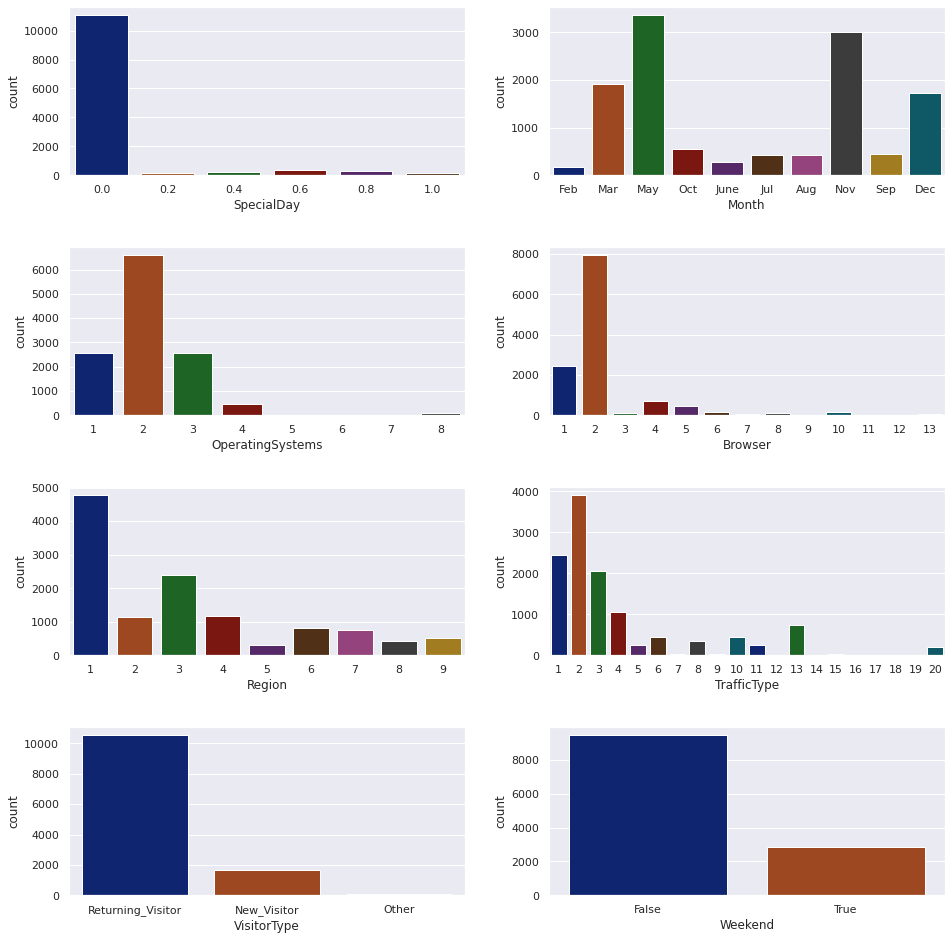

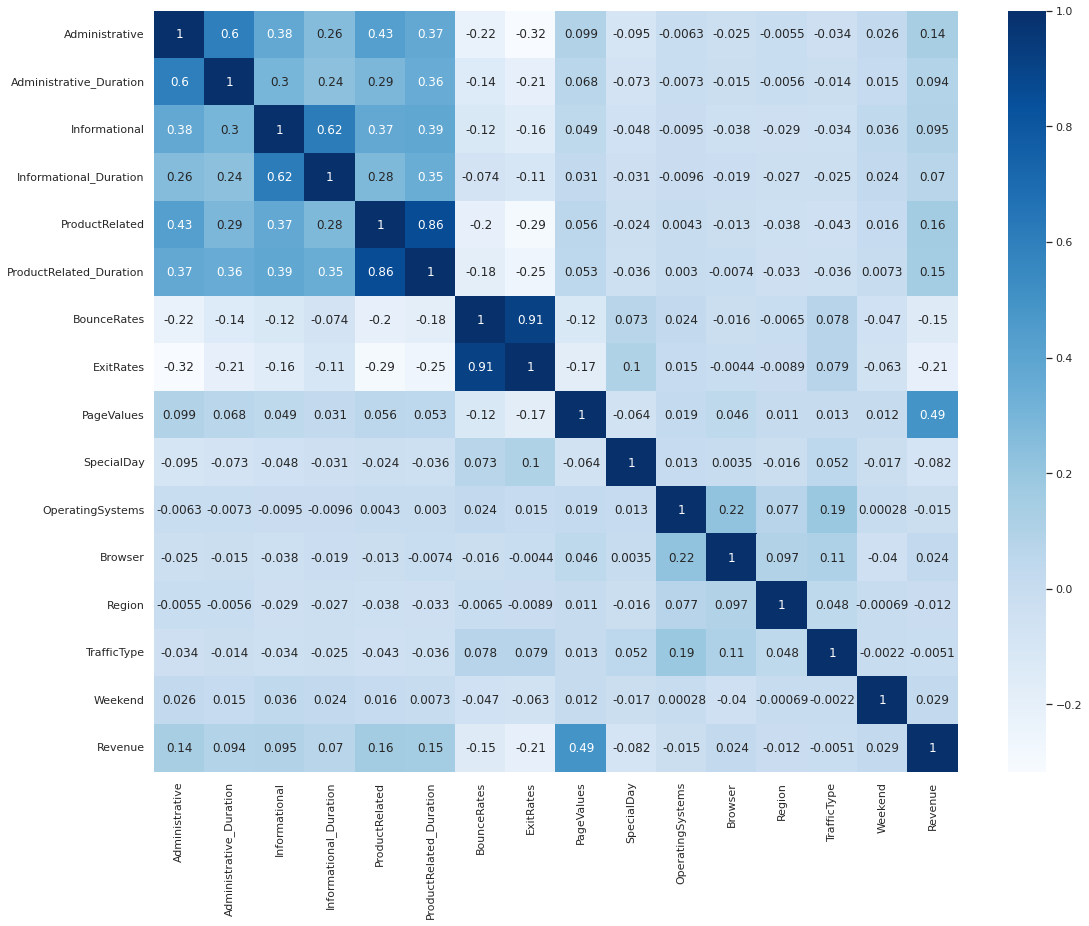

Total number of duplicate rows:  125
Drop of duplicate rows ...
Drop carried out.
Total number of duplicate rows:  0

Sample of Data :
       Administrative  Administrative_Duration  ...  Weekend  Revenue
3728                2                   15.000  ...    False    False
10075               1                  139.500  ...    False    False
6675                4                   80.600  ...    False    False
3413                7                   41.375  ...    False    False
8827                3                   36.000  ...    False     True

[5 rows x 18 columns]

Description of data :
                           count         mean  ...          75%           max
Administrative           12205.0     2.338878  ...     4.000000     27.000000
Administrative_Duration  12205.0    81.646331  ...    94.700000   3398.750000
Informational            12205.0     0.508726  ...     0.000000     24.000000
Informational_Duration   12205.0    34.825454  ...     0.000000   2549.375000
ProductRe

In [ ]:
 #Analyses des données général
df1 = pd.read_csv(path)
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns', end='\n\n')
df1.info()
print()
plotting_data_analysis_other_2()

print("Total number of duplicate rows: ", df1.duplicated().sum())
print("Drop of duplicate rows ...")
print("Drop carried out.")
df1.drop_duplicates(inplace=True)
print("Total number of duplicate rows: ", df1.duplicated().sum(), end='\n\n')
print("Sample of Data :")
print(df1.sample(5), end="\n\n")
print("Description of data :")
print(df1.describe().T)
print()

print("Convert Colmuns(OperatingSystems, Browser, Region, TrafficType) to String..")
df1.OperatingSystems = df1.OperatingSystems.astype(str)
df1.Browser = df1.Browser.astype(str)
df1.Region = df1.Region.astype(str)
df1.TrafficType = df1.TrafficType.astype(str)
print("Columns converted to string")
print()
#Fin d'analyse des données général

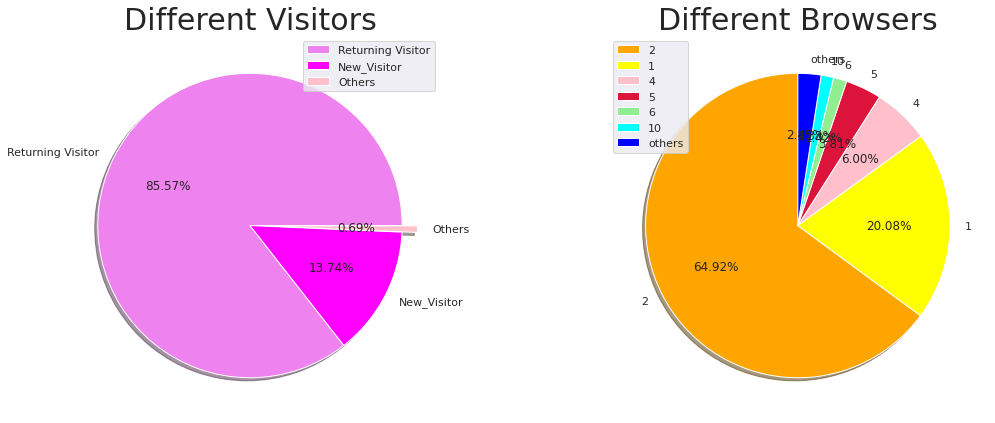

In [ ]:
#Analyses des données Revenue
#Nous cherchons à comprendre les achats des gens sur internet
#L'achat ici est reprensté par le Revenue
df1 = pd.read_csv(path)
plotting_visitor_and_browser_pie()

** Multivariate analysis

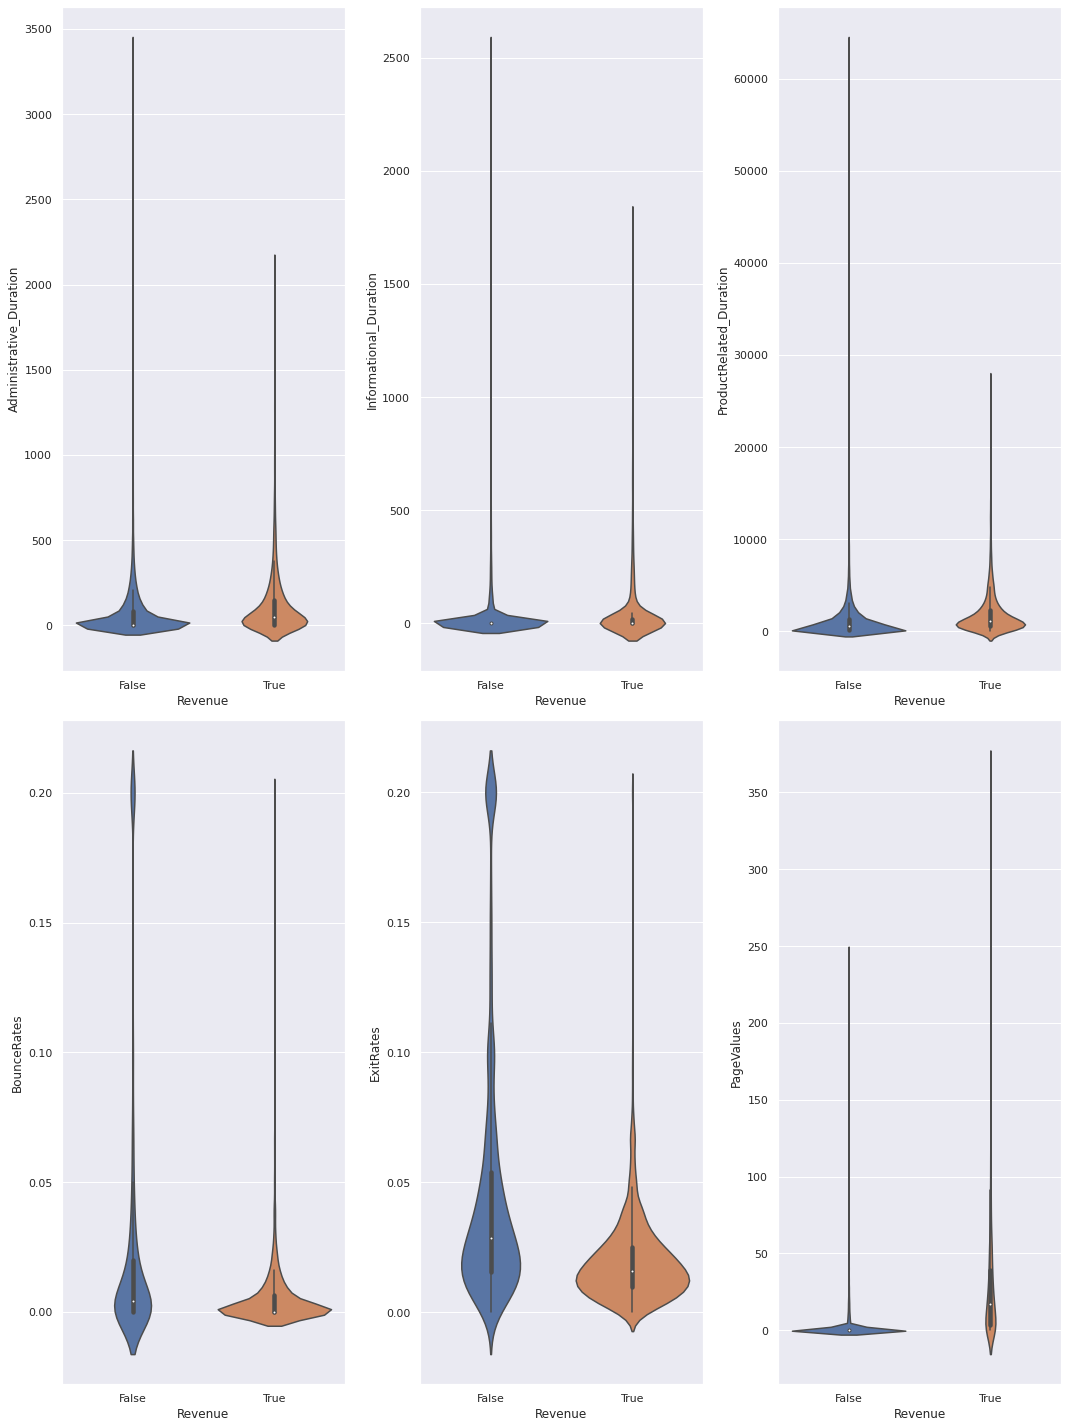

In [ ]:
#Comprenons maintenants les acheteurs
df1 = pd.read_csv(path)
Other_plotting_other_variables()

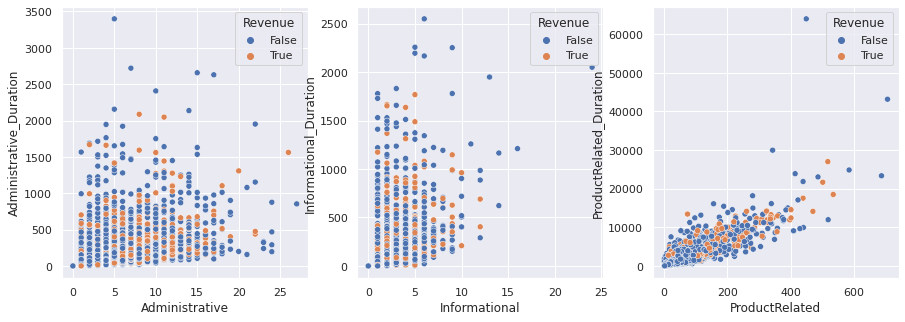

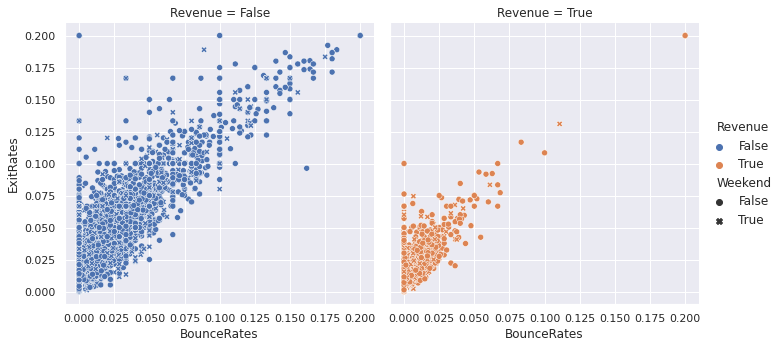

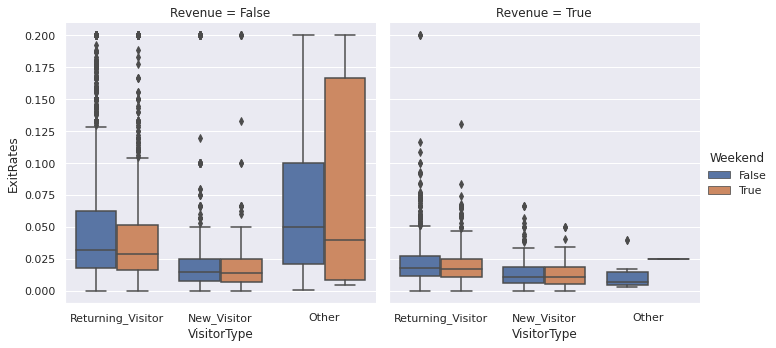

In [ ]:
plotting_data_analysis_revenue_false_true()

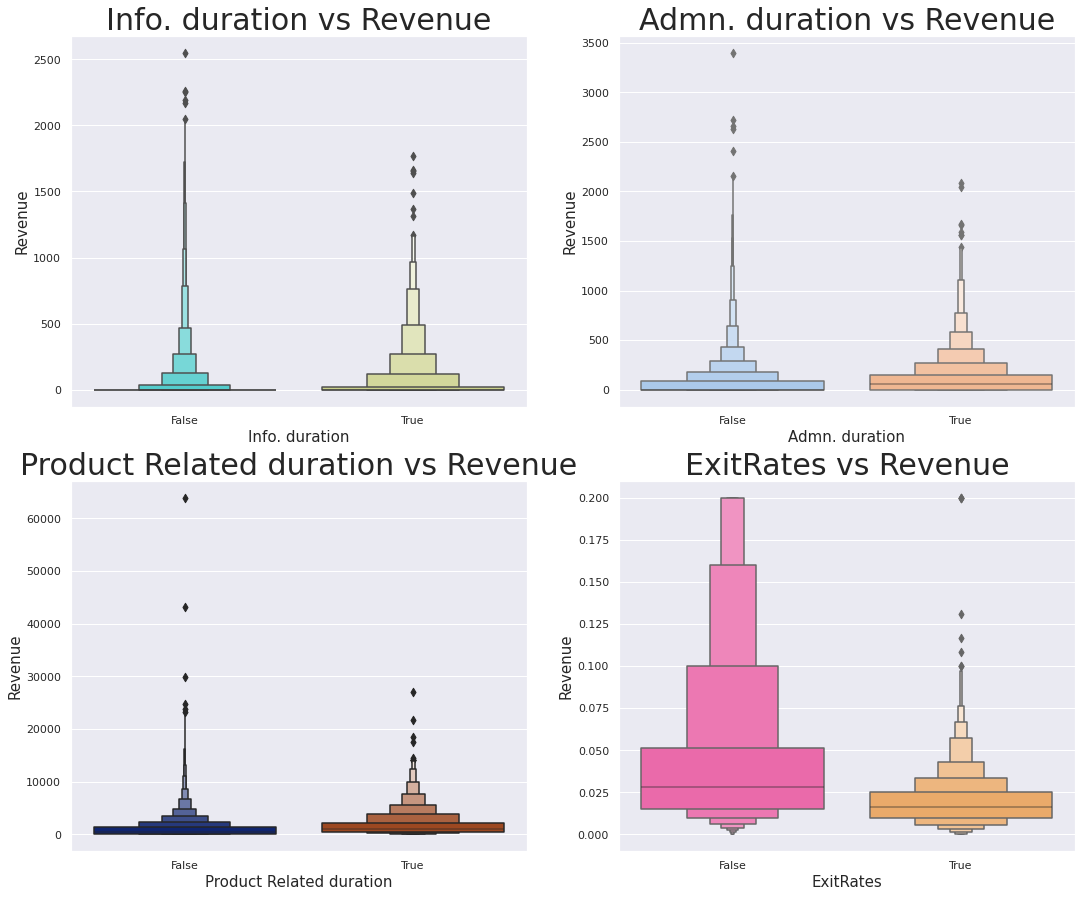

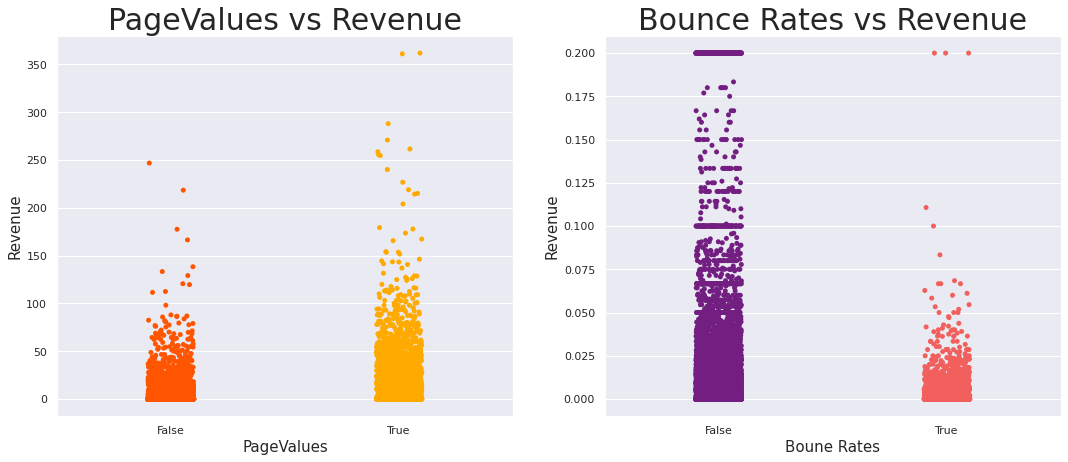

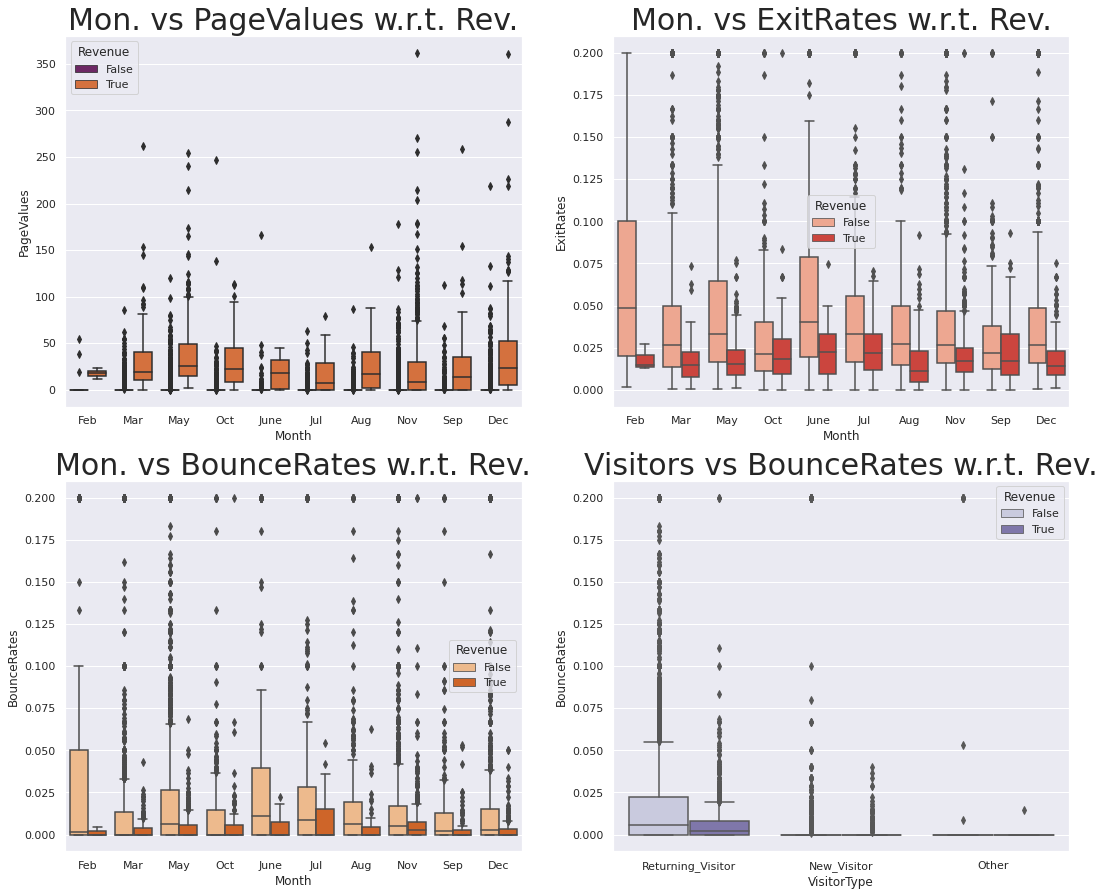

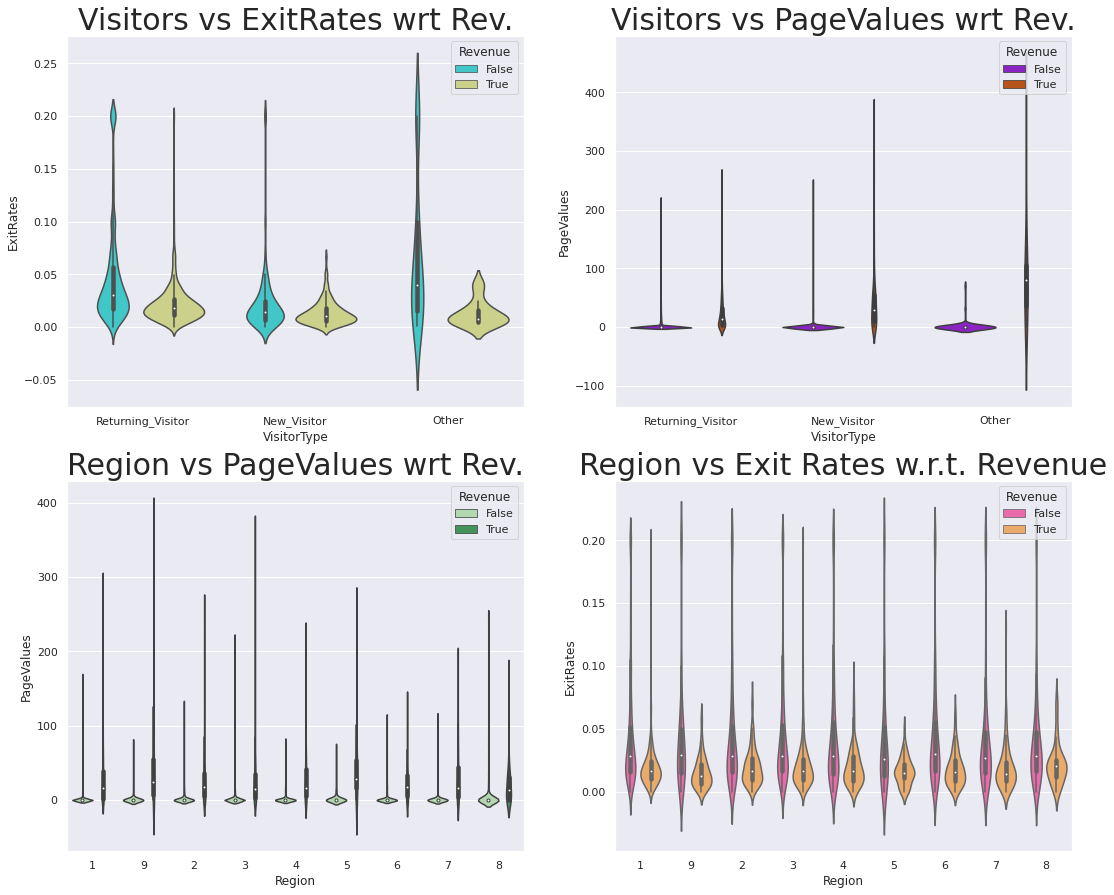

In [ ]:
plotting_interersting()
#Fin d'analyse des données Revenue

Graphics with linear regression

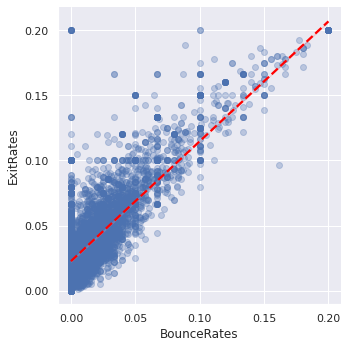

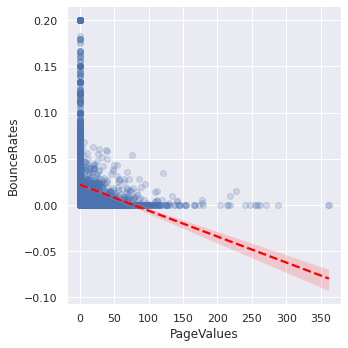

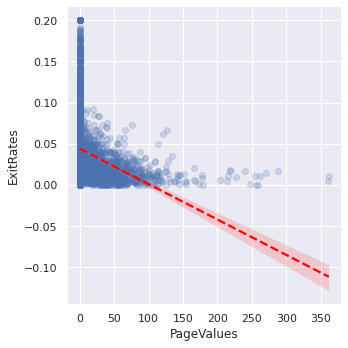

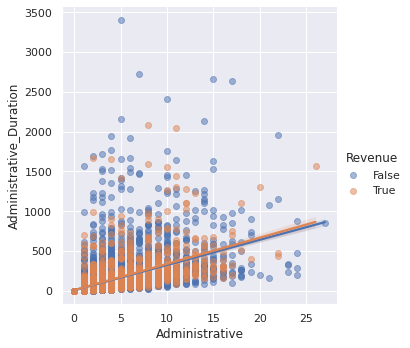

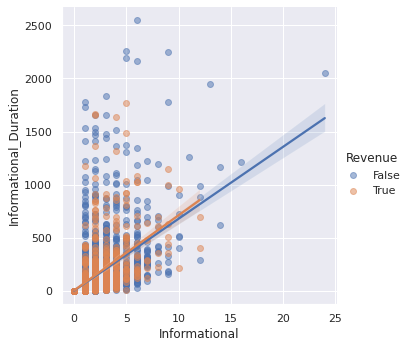

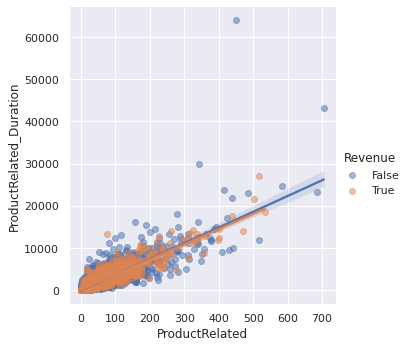

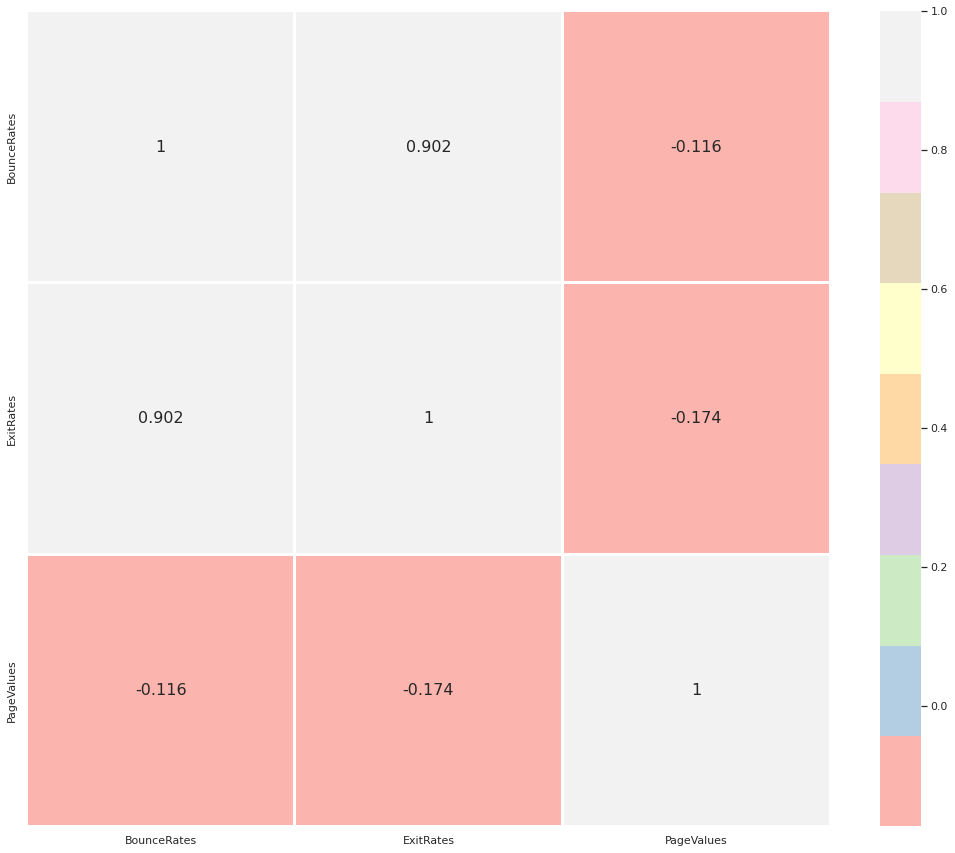

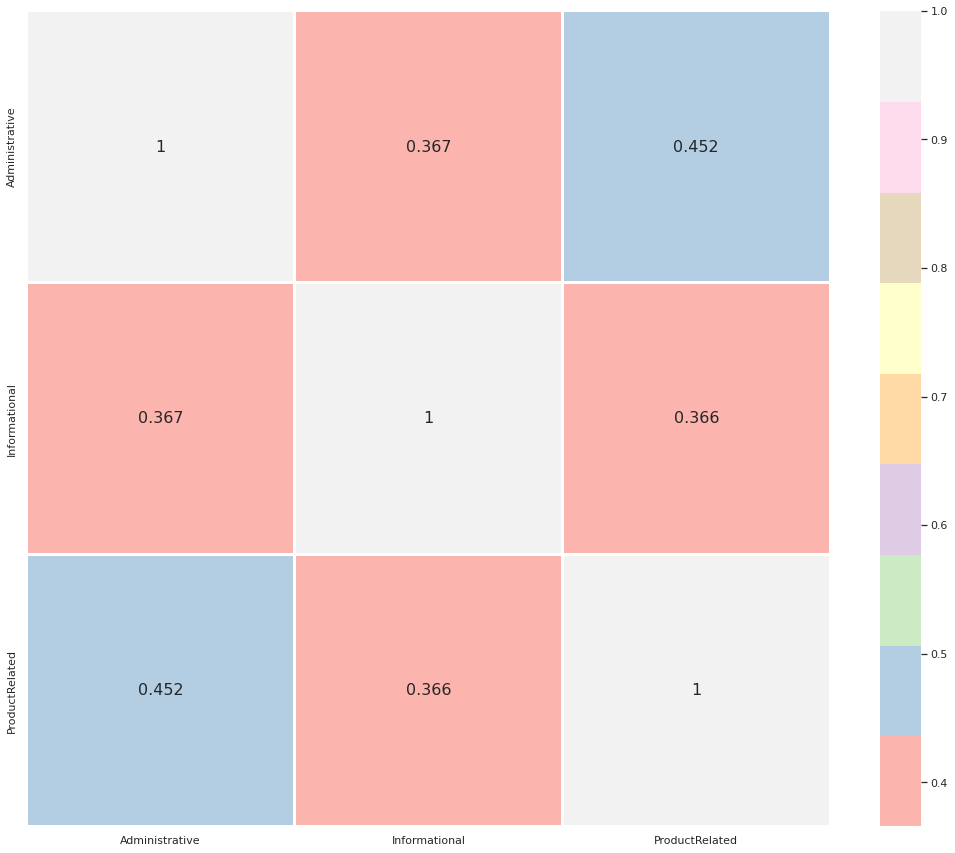

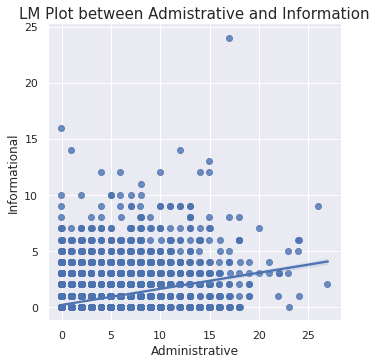

In [ ]:
#Analyses des données par regression linéar et HeatMap - A trier
plotting_LR_HeatMap()
#Fin d'analyses regression linéar et HeatMap

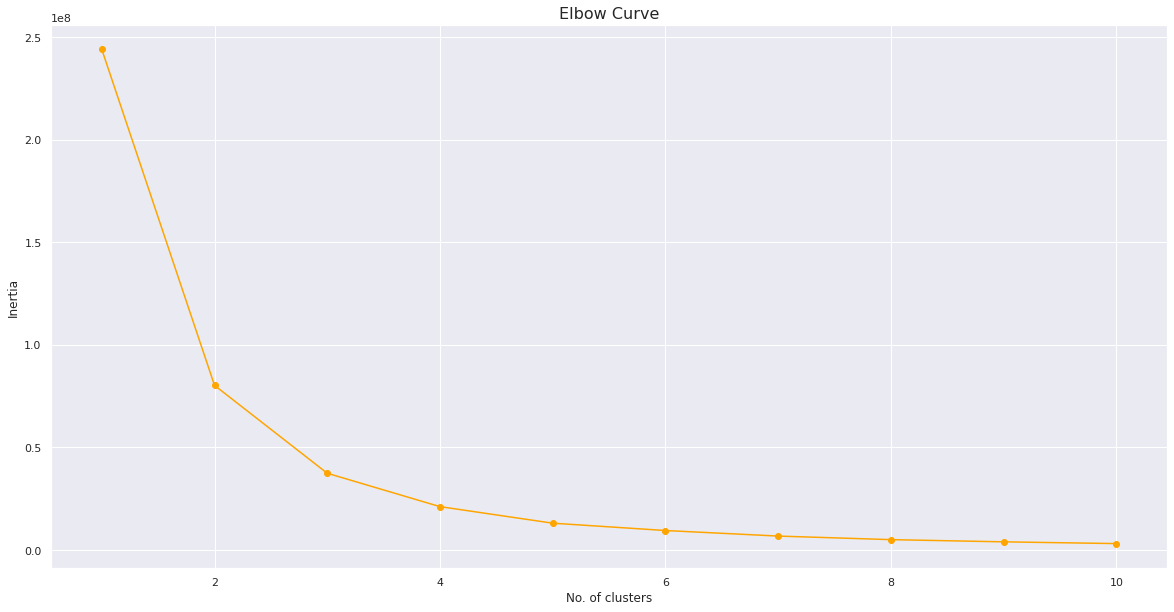

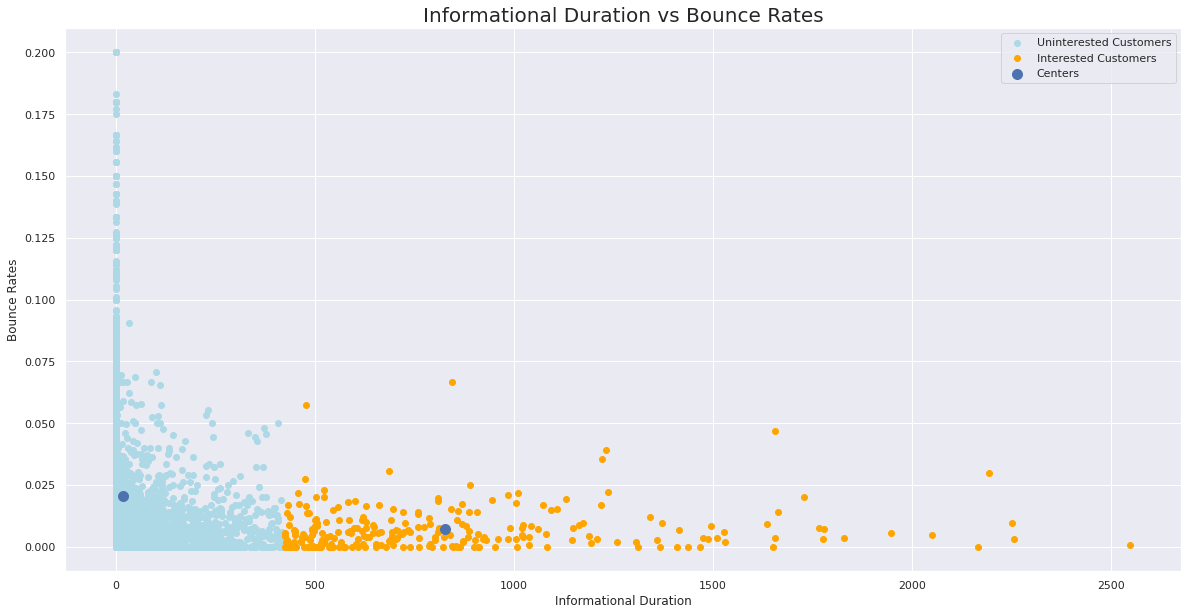

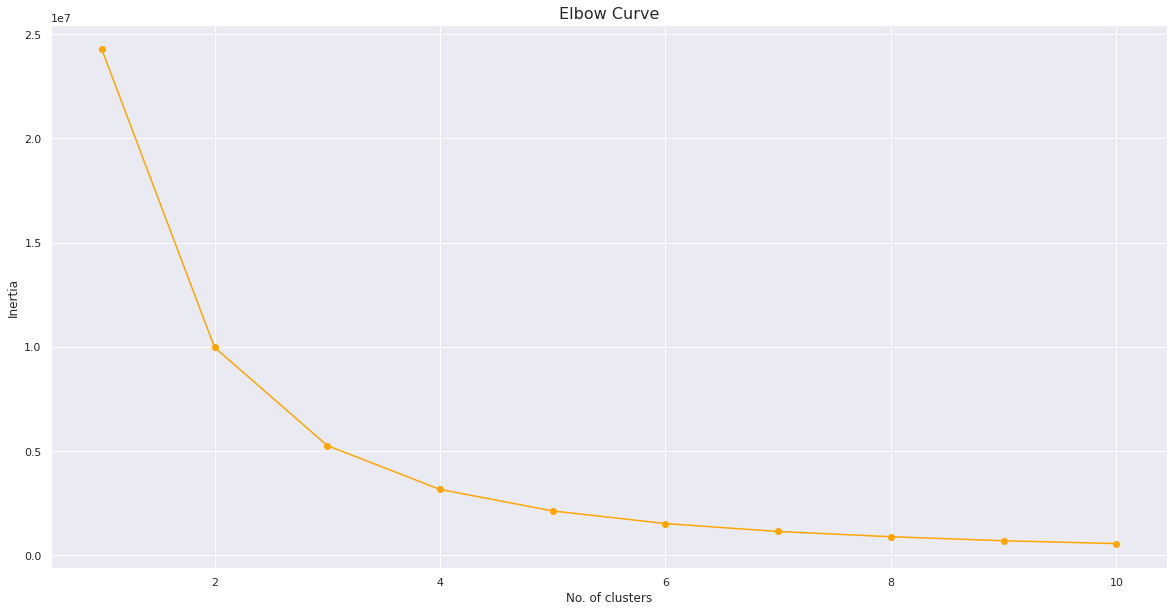

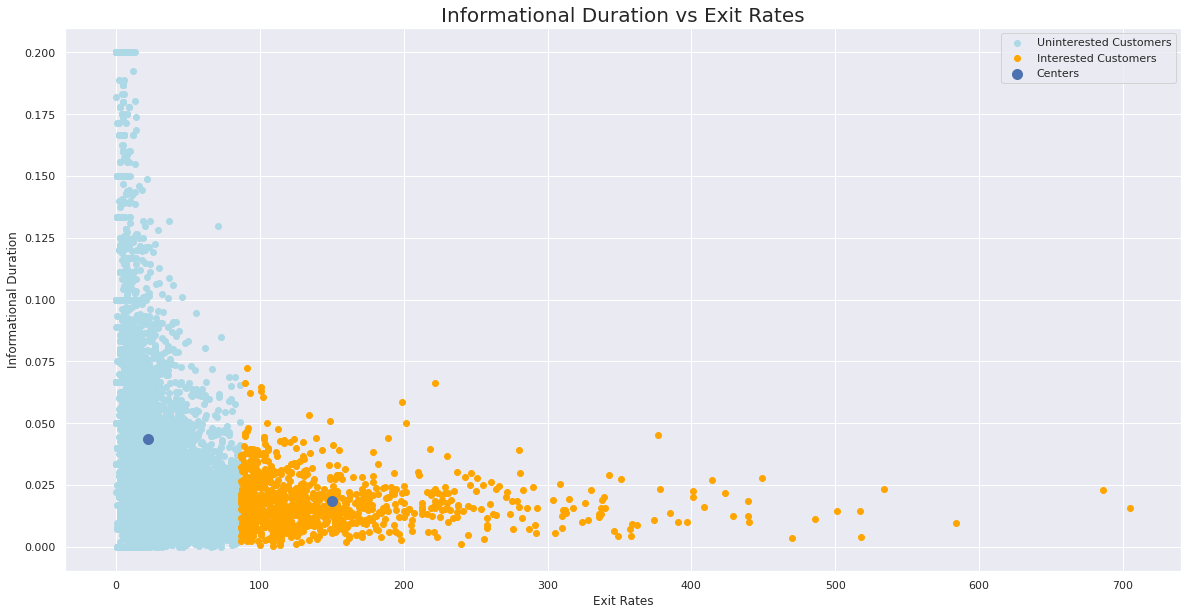

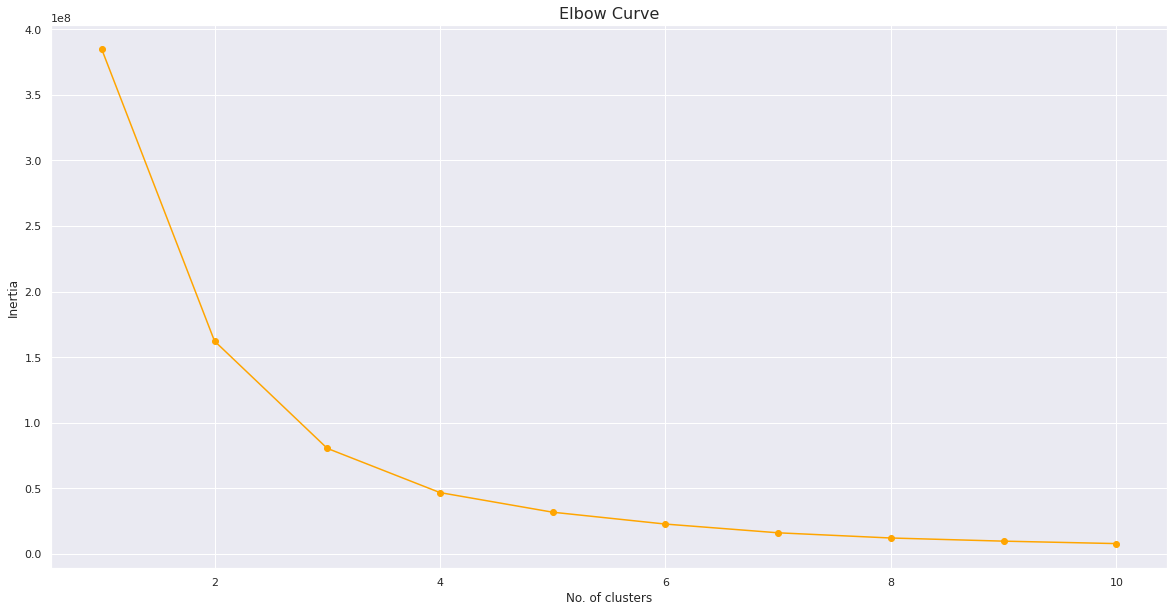

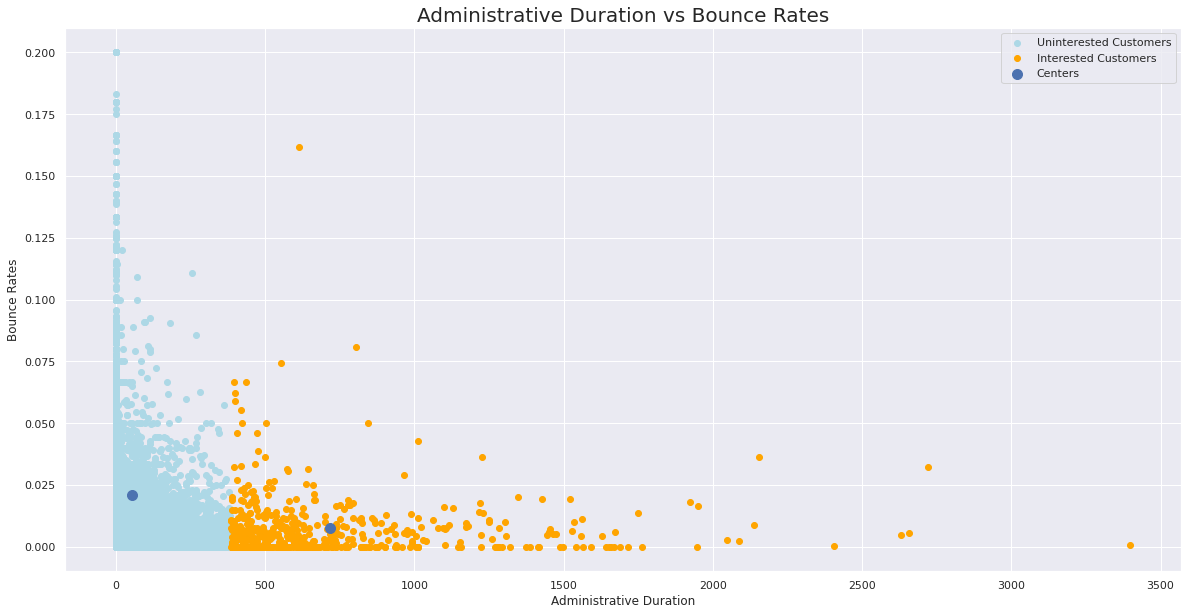

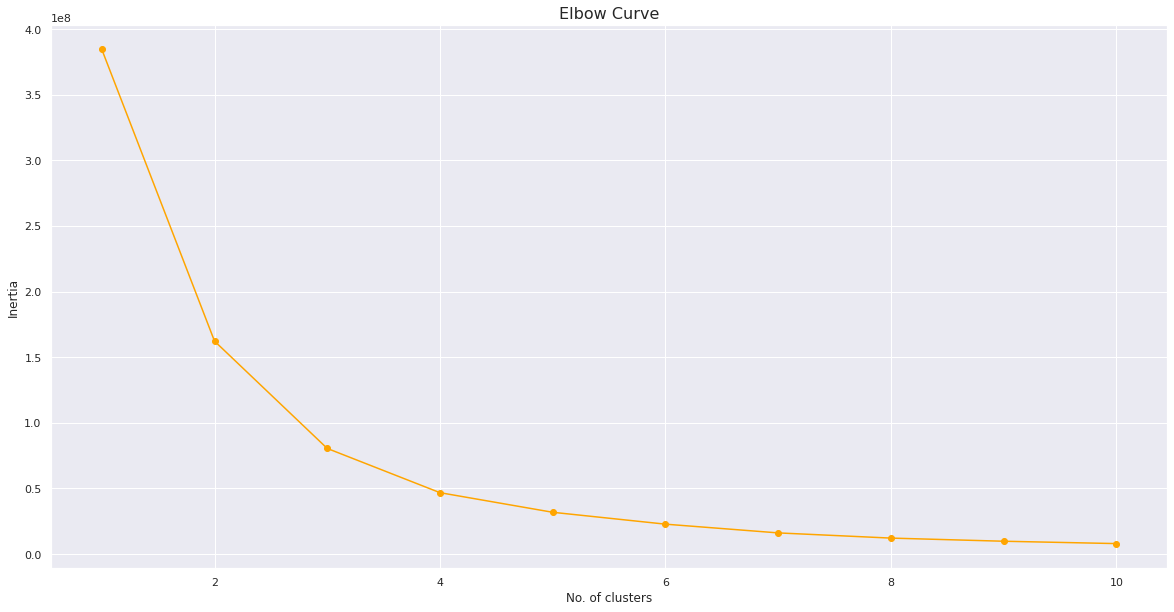

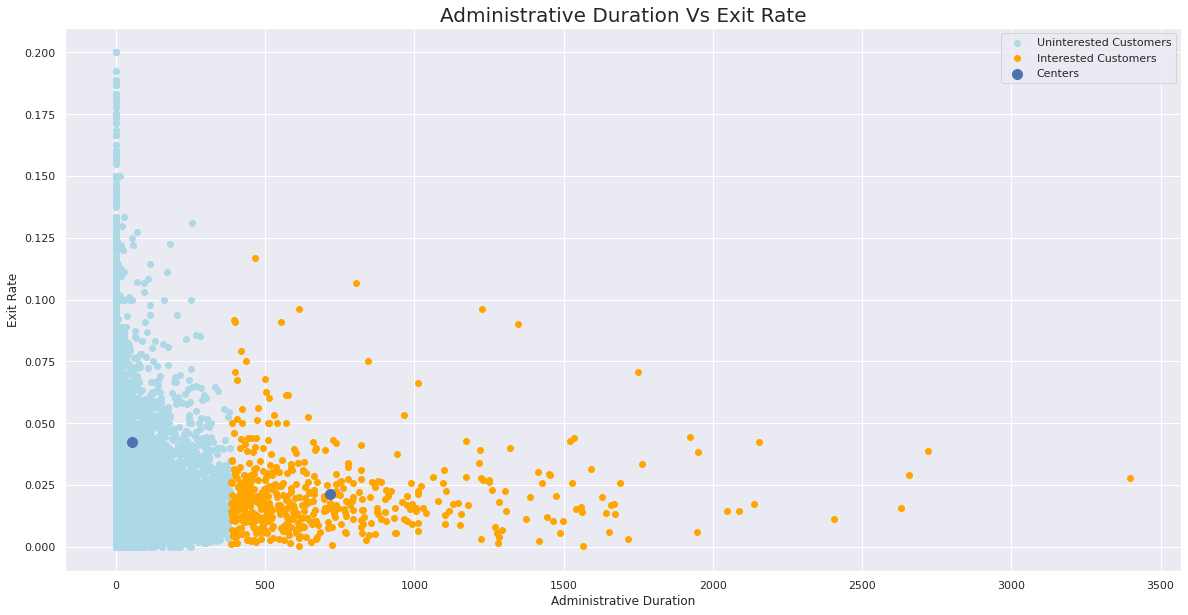

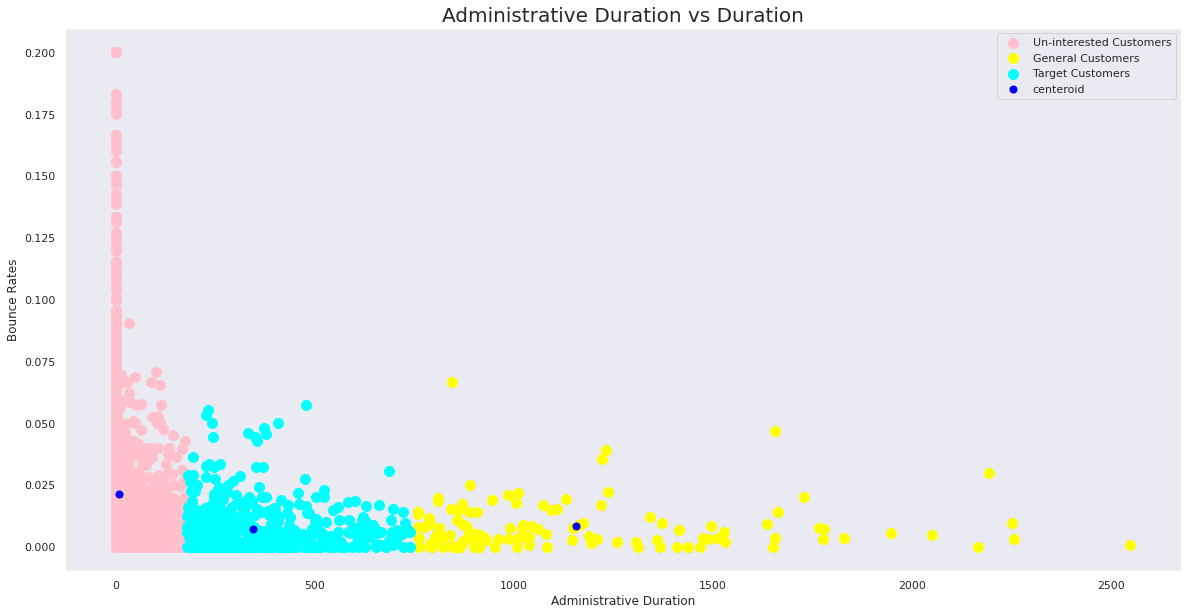

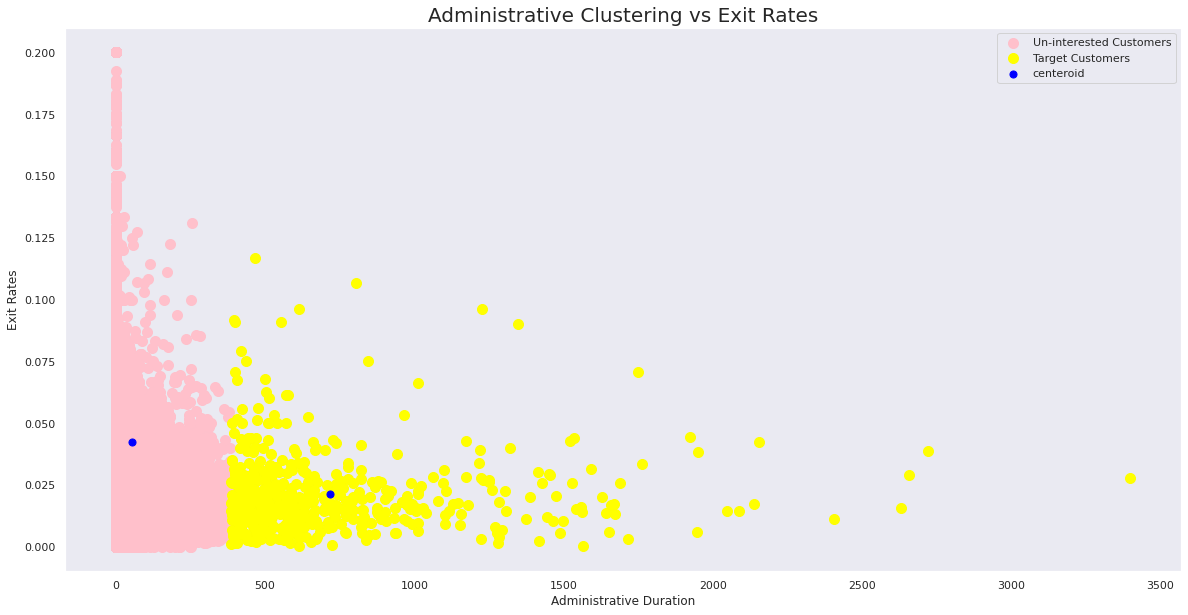

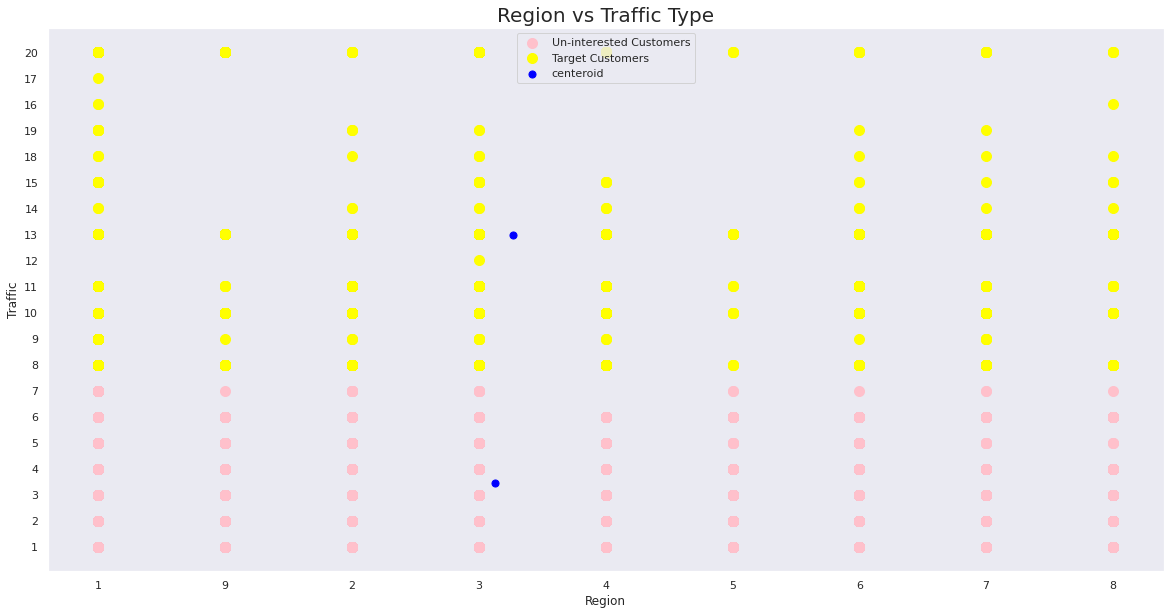

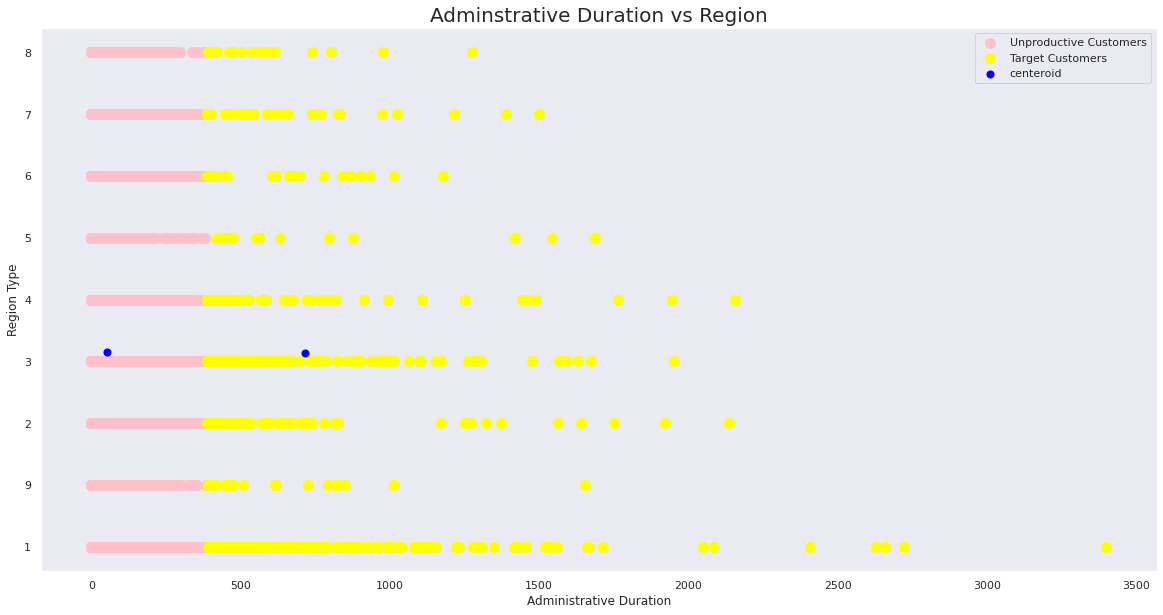

In [ ]:
#Analyses des données par K-Means - A trier
K_Means()
#Fin d'analyses K-Means

**Processing of the data **

In [ ]:
#Data processing and Model
#Convert categorical variable into dummy/indicator variables.
print("Convert categorical variable into dummy/indicator variables.")
df1 = pd.read_csv(path)
data1 = pd.get_dummies(df1)
# label encoding of revenue
le = LabelEncoder()
print("Type of label before Label Encoder : ",data1['Revenue'].dtype)
print("Label Encoder of Revenue ...")
data1['Revenue'] = le.fit_transform(data1['Revenue'])
data1['Revenue'].value_counts()
print("Type of label after Label Encoder : ", data1['Revenue'].dtype)
print()
#
# getting dependent and independent variables
x = data1
# removing the target column revenue from x
x = x.drop(['Revenue'], axis=1)
y = df1['Revenue']
# checking the shapes
print("Shape of x:", x.shape)
print("Shape of y:", y.shape)
print()

Convert categorical variable into dummy/indicator variables.
Type of label before Label Encoder :  bool
Label Encoder of Revenue ...
Type of label after Label Encoder :  int64

Shape of x: (12330, 28)
Shape of y: (12330,)



In [ ]:
# splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
# checking the shapes
print("Shape of x_train :", x_train.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_test :", y_test.shape)
print()

Shape of x_train : (9864, 28)
Shape of y_train : (9864,)
Shape of x_test : (2466, 28)
Shape of y_test : (2466,)



** All model of machine learning with Random Forest 1 and 2, Gaussian Naive Bayes and Extra trees **

Metrics RandomForest : 
Training Accuracy : 1.0
Testing Accuracy : 0.8917274939172749
              precision    recall  f1-score   support

       False       0.91      0.96      0.94      2044
        True       0.76      0.54      0.63       422

    accuracy                           0.89      2466
   macro avg       0.83      0.75      0.78      2466
weighted avg       0.88      0.89      0.88      2466



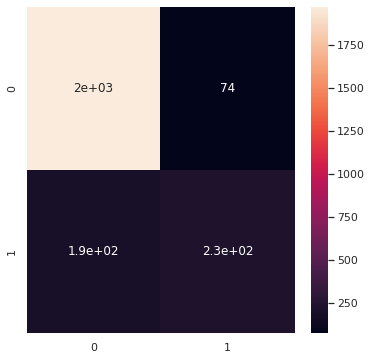

['./random_forest_technical_1.joblib']

In [ ]:
# RandomForest_28 classifier
# MODELLING
model = RandomForestClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
# evaluating the model
print("Metrics RandomForest : ")
print("Training Accuracy :", model.score(x_train, y_train))
print("Testing Accuracy :", model.score(x_test, y_test))
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (6, 6)
sns.heatmap(cm, annot=True)
# classification report
cr = classification_report(y_test, y_pred)
print(cr)
plt.show()

joblib.dump(model, "./random_forest_technical_1.joblib")

In [ ]:
# Removing unneccessary columns from data: shopping_clean
#----------------------------------------------------------
df1 = pd.read_csv(path)
shopping_clean = df1.drop(['Month', 'Browser', 'OperatingSystems', 'Region', 'TrafficType', 'Weekend'], axis=1)
# Encoding Vistor Type
visitor_encoded = pd.get_dummies(shopping_clean['VisitorType'], prefix='Visitor_Type', drop_first=True)
shopping_clean_merged = pd.concat([shopping_clean, visitor_encoded], axis=1).drop(['VisitorType'], axis=1)
# Split train and test data
X = shopping_clean_merged.drop('Revenue', axis=1)
y = shopping_clean_merged['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=.2)

models_accuracy = {"RandomForest" : 1, 
          "Fit Gaussian Naive Bayes": 2,
          "Fit Extra Trees": 3}

models = {"RandomForest" : 1, 
          "Fit Gaussian Naive Bayes": 2,
          "Fit Extra Trees": 3}

In [ ]:
print("Data before cleaning : ", df1.info())
print()
print("Dara after cleaning : ", shopping_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

** Gaussian Naive Bayes **

Gaussian Naive Bayes model accuracy(in %): 84.63


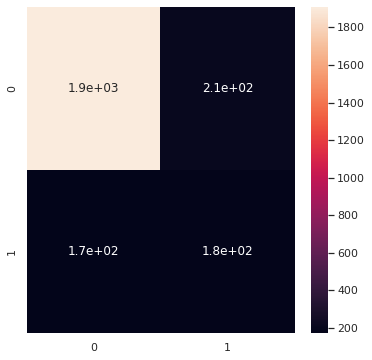

['./GaussianNB_technical_2.joblib']

In [ ]:
# Normalization:
#x = (x - nр.min(x)) / (nр.mаx(x) - nр.min(x))

#----------------------------------------------------------
# Fit Gaussian Naive Bayes Classifier to our training data
gnb = GaussianNB()
gnb.fit(X_train, y_train)
# Make prediction using our test data and model
y_pred = gnb.predict(X_test)
# Comparing our prediction to response values
accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
print("Gaussian Naive Bayes model accuracy(in %):", accuracy)

cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (6, 6)
sns.heatmap(cm, annot=True)
plt.show()

models_accuracy['Fit Gaussian Naive Bayes'] = accuracy
joblib.dump(gnb, "./GaussianNB_technical_2.joblib")

** Random Forest Classifier **

Random Forest Classifier model accuracy(in %): 90.23


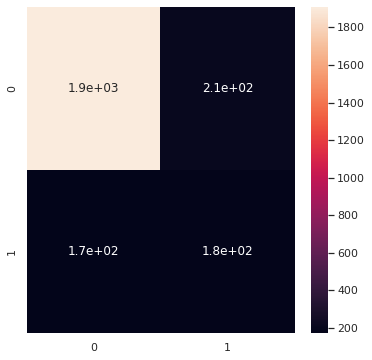

['./RandomForest_technical_2.joblib']

In [ ]:
# Fit Random Forest Classifier to our Training Data
rfc = RandomForestClassifier(max_depth=5, random_state=2, n_estimators=750)
rfc.fit(X_train, y_train)
# make prediction using our test data and model
y_pred_rfc = rfc.predict(X_test)
y_prob_rfc = rfc.predict_proba(X_test)[:, 1]
# Comparing our prediciton to response values
accuracy =  round(metrics.accuracy_score(y_test, y_pred_rfc) * 100, 2)
print('Random Forest Classifier model accuracy(in %):', accuracy)
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (6, 6)
sns.heatmap(cm, annot=True)
plt.show()

models_accuracy['RandomForest'] = accuracy
joblib.dump(rfc, "./RandomForest_technical_2.joblib")

The area under the ROC curve is: 0.89


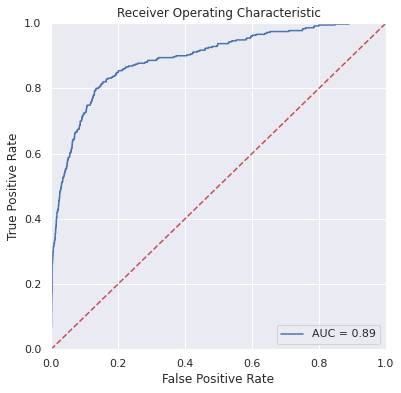

In [ ]:
# Calculate ROC AUC for our best performing classifier, the Random Forest Classifier
roc_value = roc_auc_score(y_test, y_prob_rfc)
print('The area under the ROC curve is:', round(roc_value, 2))
fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob_rfc)
roc_auc = metrics.auc(fpr, tpr)
# Plotting ROC Curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

** Extra trees **

Extra Trees Classifier model accuracy(in %): 89.5


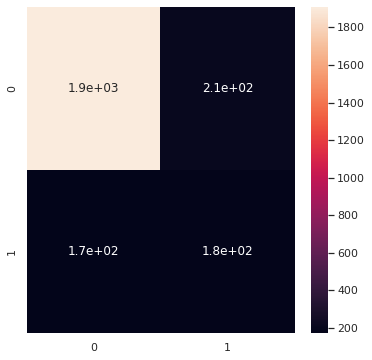

['./ExtraTreesClassifier_technical_2.joblib']

In [ ]:
# Fit Extra Trees Classifier to our Training Data
etc = ExtraTreesClassifier(random_state=2, n_estimators=1000)
etc.fit(X_train, y_train)
# make prediction using our test data and model
y_pred_etc = etc.predict(X_test)
y_prob_etc = etc.predict_proba(X_test)[:, 1]
# Comparing our prediciton to response values
accuracy = round(metrics.accuracy_score(y_test, y_pred_etc) * 100, 2)
print('Extra Trees Classifier model accuracy(in %):', accuracy)

cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (6, 6)
sns.heatmap(cm, annot=True)
plt.show()

models_accuracy['Fit Extra Trees'] = accuracy
joblib.dump(etc, "./ExtraTreesClassifier_technical_2.joblib")

** Important and best models with the most important variables **

{'RandomForest': 90.23, 'Fit Gaussian Naive Bayes': 84.63, 'Fit Extra Trees': 89.5}
The best model is :  RandomForest
The best accuracy is :  90.23 %



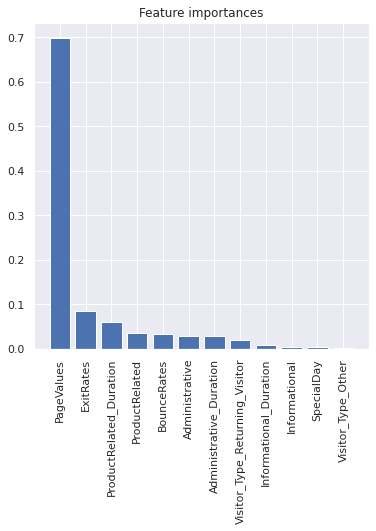

Feature ranking:
1. Feature 8 (0.698107)
2. Feature 7 (0.084048)
3. Feature 5 (0.059141)
4. Feature 4 (0.035484)
5. Feature 6 (0.033370)
6. Feature 0 (0.028572)
7. Feature 1 (0.028051)
8. Feature 11 (0.018375)
9. Feature 3 (0.007560)
10. Feature 2 (0.004090)
11. Feature 9 (0.002665)
12. Feature 10 (0.000538)


In [ ]:
#Importances and Best Model
max_key = max(models_accuracy, key=models_accuracy.get)
print(models_accuracy)
print("The best model is : ", max_key)
print("The best accuracy is : ", models_accuracy[max_key], "%")
print()
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
              axis=0)
indices = np.argsort(importances)[::-1]

# Generating a dataframe for our feature importance
col_names = pd.Series([col for col in X_test.columns])
importance_df = pd.DataFrame(importances)
importance_df.rename(columns={0: 'Importance'}, inplace=True)
importance_df.set_index(col_names, inplace=True)
imp_sorted = importance_df.sort_values(by='Importance', ascending=False)
imp_sorted

plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices])
plt.xticks(range(X_test.shape[1]), imp_sorted.index, rotation=90)
plt.xlim([-1, X_test.shape[1]])
plt.show()

print("Feature ranking:")
for f in range(X_test.shape[1]):
    print("%d. Feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))